In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('../data/names.txt', 'r').read().splitlines()
len(words)

32033

In [3]:
chars = ["."] + sorted(list(set(''.join(words))))
stoi = {s:i for i,s in enumerate(chars)}
itos = {i:s for s,i in stoi.items()}
print(itos)

{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [4]:
def build_dataset(words):
    block_size = 3
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(1029384756)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [91]:
class MakeMore:
    def __init__(self, emb_size=2, block_size=3, hidden_size=100):
        g = torch.Generator().manual_seed(2147483647)
        self.emb_size = emb_size
        self.block_size = block_size
        self.C = torch.randn((27, emb_size), generator=g)
        self.W1 = torch.randn((emb_size * block_size, hidden_size), generator=g)
        self.b1 = torch.randn(hidden_size, generator=g)
        self.W2 = torch.randn((hidden_size, 27), generator=g)
        self.b2 = torch.randn(27, generator=g)
        self.parameters = [self.C, self.W1, self.b1, self.W2, self.b2]
        self.regularization_params = [self.C, self.W1, self.W2] # we do not regularize the biases, bengio 2003 p.6
        for p in self.parameters:
            p.requires_grad = True

    def train(self, X, Y, batch_size=32, num_steps=50000, lr_fn=lambda pct: 0.1 if pct < 0.9 else 0.01):
        for i in range(num_steps):
            ix = torch.randint(0, X.shape[0], (batch_size,))
    
            # forward pass
            loss = self.eval_loss(X[ix], Y[ix])
            # emb = self.C[X[ix]] # batch_size x block_size x emb_size
            # h = torch.tanh(emb.view(-1, self.emb_size * self.block_size) @ self.W1 + self.b1) # batch_size x hidden_size
            # logits = h @ self.W2 + self.b2 # batch_size x 27
            # loss = F.cross_entropy(logits, Y[ix])
            # backward pass
            for p in self.parameters:
                p.grad = None
            loss.backward()
            lr = lr_fn(i / num_steps)
            for p in self.parameters:
                p.data += -1 * lr * p.grad

    def eval_loss(self, X, Y, regularization_mult=0.01):
        
        emb = self.C[X]
        h = torch.tanh(emb.view(-1, self.emb_size * self.block_size) @ self.W1 + self.b1)
        logits = h @ self.W2 + self.b2
        loss = F.cross_entropy(logits, Y)
        return loss

    def sample(self):
        out = []
        context = [0] * self.block_size
        while True:
            emb = self.C[torch.tensor([context])]
            h = torch.tanh(emb.view(1, -1) @ self.W1 + self.b1)
            logits = h @ self.W2 + self.b2
            probs = F.softmax(logits, dim=1)
            ix = torch.multinomial(probs, num_samples=1).item()
            context = context[1:] + [ix]
            out.append(ix)
            if ix == 0:
                break

        return ''.join(itos[i] for i in out)

In [97]:
mm1 = MakeMore()

In [98]:
mm1.train(Xtr, Ytr)

In [103]:
mm1.eval_loss(Xdev, Ydev)

tensor(2.3294, grad_fn=<NllLossBackward0>)

In [62]:
mm2 = MakeMore(emb_size=10)
mm2.train(Xtr, Ytr)

In [64]:
mm2.eval_loss(Xdev, Ydev).item()

2.239565849304199

In [67]:
# control for other variables, but see which embedding size is best between 2 and 20
emb_sizes = []
losses = []
for size in range(2, 21):
    mm = MakeMore(emb_size=size)
    mm.train(Xtr, Ytr)
    emb_sizes.append(size)
    losses.append(mm.eval_loss(Xdev, Ydev).item())

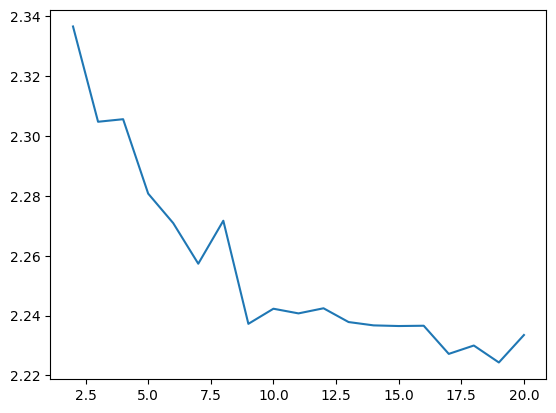

In [69]:
plt.plot(emb_sizes, losses)

In [70]:
# again from 15 to 30
emb_sizes = []
losses = []
for size in range(15, 31):
    mm = MakeMore(emb_size=size)
    mm.train(Xtr, Ytr)
    emb_sizes.append(size)
    losses.append(mm.eval_loss(Xdev, Ydev).item())

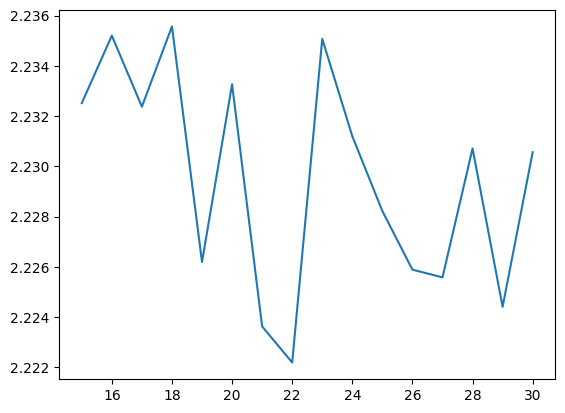

In [71]:
plt.plot(emb_sizes, losses)

In [73]:
# seems to stabilize around emb_size = 16-17. Let's go with 16

In [74]:
# hidden layer size from 50 to 200
hidden_sizes = []
losses = []
for hidden in range(50, 210, 10):
    mm = MakeMore(emb_size=16, hidden_size=hidden)
    mm.train(Xtr, Ytr)
    hidden_sizes.append(hidden)
    losses.append(mm.eval_loss(Xdev, Ydev).item())

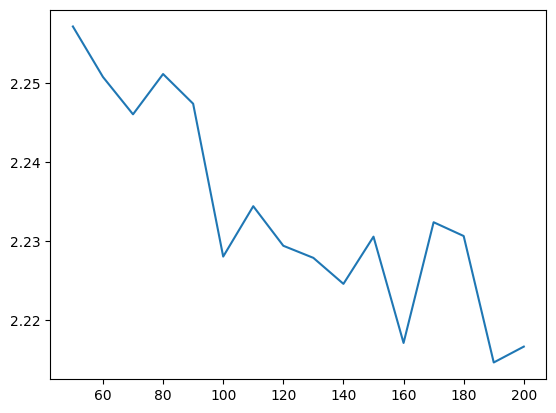

In [75]:
plt.plot(hidden_sizes, losses)

In [76]:
# again from 150 to 300
hidden_sizes = []
losses = []
for hidden in range(150, 310, 10):
    mm = MakeMore(emb_size=16, hidden_size=hidden)
    mm.train(Xtr, Ytr)
    hidden_sizes.append(hidden)
    losses.append(mm.eval_loss(Xdev, Ydev).item())

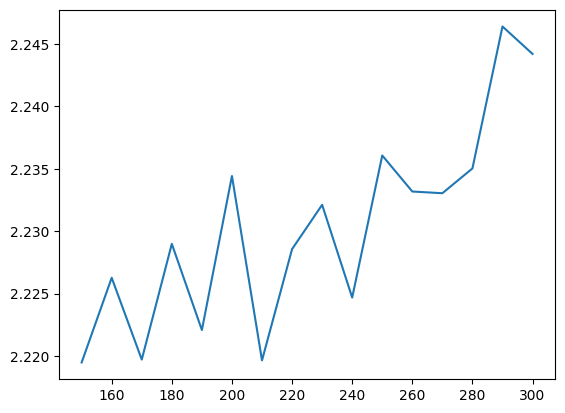

In [77]:
plt.plot(hidden_sizes, losses)

In [ ]:
# the loss is increasing, but I believe that is happening because the model is not being trained for long enough.
# let's try an extended training with our tuned hyperparameters of emb_size and hidden_size

In [78]:
# I bet if we increase the context window to 4 characters
# we could easily beat the loss

In [104]:
mmguess = MakeMore(emb_size=16, hidden_size=150)
mmguess.train(Xtr, Ytr, num_steps=200000)

In [105]:
mmguess.eval_loss(Xdev, Ydev)

tensor(2.1677, grad_fn=<NllLossBackward0>)

In [106]:
# 2.16, nice! continue training with a modified lr_fun
mmguess.train(Xtr, Ytr, num_steps=400000, lr_fn=lambda pct: 0.01 if pct < 0.9 else 0.005)

In [107]:
mmguess.eval_loss(Xdev, Ydev)

tensor(2.1589, grad_fn=<NllLossBackward0>)

In [108]:
# seems we are stabilizing around 2.15. let's test on the testing data
mmguess.eval_loss(Xte, Yte)

tensor(2.1303, grad_fn=<NllLossBackward0>)

In [110]:
for _ in range(20):
    print(mmguess.sample())

makheto.
clince.
kanabanik.
auraah.
amareegan.
dra.
keylia.
ana.
romidley.
jamn.
marehd.
marron.
sel.
vatiyatt.
amazaan.
jermeen.
marrie.
avyer.
ruhi.
kad.


In [111]:
mmhuge = MakeMore(emb_size=16, hidden_size=300)

In [118]:
mmhuge.train(Xtr, Ytr, num_steps=400000, lr_fn=lambda pct: 0.01 if pct < 0.9 else 0.005)

In [119]:
mmhuge.eval_loss(Xdev, Ydev)

tensor(2.1406, grad_fn=<NllLossBackward0>)